In [ ]:
# Code structure initially based from Dr. Gerald Schuller's online presentation. Available at:
# https://raw.githubusercontent.com/GuitarsAI/MLfAS/master/MLAS_08_Variational_Autoencoder.ipynb

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device=", device)

device= cpu


In [ ]:
# Variational loss functions for mean and std
def variational_loss(mu, std):
    #returns the varialtional loss from arguments mean and standard deviation
    #see also: see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    #https://arxiv.org/abs/1312.6114
    vl=-0.5*torch.mean(1+ 2*torch.log(std)-mu.pow(2) -(std.pow(2)))
    return vl
   
def variational_loss2(mu, std):
    #returns the varialtional loss from arguments mean and standard deviation
    #alternative: mean squared distance from ideal mu=0 and std=1:
    vl=torch.mean(mu.pow(2)+(1-std).pow(2))
    return vl

In [ ]:
import torch.nn as nn 
# Init VAE framework 
class Convautoenc(nn.Module):
    def __init__(self):
        super(Convautoenc, self).__init__()
        #Analysis Filterbank with downsampling of N=8*1024, filter length of 2N, but only 32 outputs:
        #for the mean values:
        self.conv1mean=nn.Conv1d(in_channels=1, out_channels=512, kernel_size=1*2048, stride=1*1024, padding=1*1024-1, bias=True) #Padding for 'same' filters (kernel_size/2-1)
       #for the standard devieation values:
        self.conv1std=nn.Conv1d(in_channels=1, out_channels=512, kernel_size=1*2048, stride=1*1024, padding=1*1024-1, bias=True) #Padding for 'same' filters (kernel_size/2-1)

       #Synthesis filter bank:
        self.synconv1=nn.ConvTranspose1d(in_channels=512, out_channels=1, kernel_size=1*2048, stride=1*1024, padding=1*1024-1, bias=True)

    def encodermean(self, x):
        #Analysis:
        x = self.conv1mean(x)
        y = torch.tanh(x)
        return y

    def encoderstd(self, x):
        #Analysis:
        x = self.conv1std(x)
        y = torch.abs(torch.tanh(x))
        return y

    def decoder(self, y):
        #Synthesis:
        xrek= self.synconv1(y)
        return xrek

    def forward(self, x):
        Yencmean=model.encodermean(x)
        Yencstd=model.encoderstd(x)
        #Yvariational= torch.normal(Yencmean, Yencstd)
        Yvariational= Yencmean + Yencstd*torch.randn_like(Yencstd)
        #for the randn_like see also: https://github.com/pytorch/examples/blob/master/vae/main.py
        Ypred=model.decoder(Yvariational)
        return Ypred, Yencmean, Yencstd

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import scipy.io.wavfile as wav

if sys.version_info[0] < 3:
    # for Python 2
    import cPickle as pickle
else:
    # for Python 3
    import pickle
   
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device=", device)

device= cpu


In [ ]:
def signal2pytorch(x):
    #Function to convert a signal vector x, like a mono audio signal, into a 3-d Tensor that conv1d of Pytorch expects,
    #https://pytorch.org/docs/stable/nn.html
    #Argument x: a 1-d signal as numpy array
    #input x[batch,sample]
    #output: 3-d Tensor X for conv1d input.
    #for conv1d Input: (N,Cin,Lin), Cin: numer of input channels (e.g. for stereo), Lin: length of signal, N: number of Batches (signals) 
    X = np.expand_dims(x, axis=0)  #add channels dimension (here only 1 channel)
    if len(x.shape)==1: #mono:
        X = np.expand_dims(X, axis=0)  #add batch dimension (here only 1 batch)
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)
    X=X.permute(1,0,2)  #make batch dimension first
    return X

In [ ]:
class Convautoenc(nn.Module):
    def __init__(self):
        super(Convautoenc, self).__init__()
        #Analysis Filterbank with downsampling of N=8*1024, filter length of 2N, but only 32 outputs:
        #for the mean values:
        self.conv1mean=nn.Conv1d(in_channels=1, out_channels=512, kernel_size=1*2048, stride=1*1024, padding=1*1024-1, bias=True) #Padding for 'same' filters (kernel_size/2-1)
        #for the standard devieation values:
        self.conv1std=nn.Conv1d(in_channels=1, out_channels=512, kernel_size=1*2048, stride=1*1024, padding=1*1024-1, bias=True) #Padding for 'same' filters (kernel_size/2-1)

        #Synthesis filter bank:
        self.synconv1=nn.ConvTranspose1d(in_channels=512, out_channels=1, kernel_size=1*2048, stride=1*1024, padding=1*1024-1, bias=True)

    def encodermean(self, x):
        #Analysis:
        x = self.conv1mean(x)
        y = torch.tanh(x)
        return y
      
    def encoderstd(self, x):
        #Analysis:
        x = self.conv1std(x)
        y = torch.abs(torch.tanh(x))
        return y
      
    def decoder(self, y):
        #Synthesis:
        xrek= self.synconv1(y)
        return xrek
      
    def forward(self, x):
        Yencmean=model.encodermean(x)
        Yencstd=model.encoderstd(x)
        #Yvariational= torch.normal(Yencmean, Yencstd)
        Yvariational= Yencmean + Yencstd*torch.randn_like(Yencstd)
        #for the randn_like see also: https://github.com/pytorch/examples/blob/master/vae/main.py
        Ypred=model.decoder(Yvariational)
        return Ypred, Yencmean, Yencstd

In [ ]:
import librosa

In [ ]:
# Signals read to tensor:
batch=400;
AUDIO_DIR = "/content/drive/MyDrive/Datasets/test_audio"
fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_1.wav') #get size of the speech files, all need to be identical
#x0, fs = librosa.load("./audio/Iron Maiden - The Number Of The Beast.mp3", mono=True, sr=None, duration=6, offset=13)
xlen=max(x0.shape)
x=np.zeros((batch,xlen))
for b in range(batch):
    # Set 7: Insects
    if b==0: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_1.wav')
    if b==1:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_2.wav')
    if b==2:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_3.wav')
    if b==3:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_4.wav')
    if b==4:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_5.wav')
    if b==5: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_6.wav')
    if b==6:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_7.wav')
    if b==7:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_8.wav')
    if b==8:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_9.wav')
    if b==9:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_10.wav')
    if b==10: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_11.wav')
    if b==11:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_12.wav')
    if b==12:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_13.wav')
    if b==13:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_14.wav')
    if b==14:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_15.wav')
    if b==15: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_16.wav')
    if b==16:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_17.wav')
    if b==17:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_18.wav')
    if b==18:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_19.wav')
    if b==19:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_20.wav')
    if b==20: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_21.wav')
    if b==21:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_22.wav')
    if b==22:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_23.wav')
    if b==23:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_24.wav')
    if b==24:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_25.wav')
    if b==25: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_26.wav')
    if b==26:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_27.wav')
    if b==27:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_28.wav')
    if b==28:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_29.wav')
    if b==29:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_30.wav')
    if b==30: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_31.wav')
    if b==31:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_32.wav')
    if b==32:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_33.wav')
    if b==33:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_34.wav')
    if b==34:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_35.wav')
    if b==35: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_36.wav')
    if b==36:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_37.wav')
    if b==37:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_38.wav')
    if b==38:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_39.wav')
    if b==39:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/7_40.wav')

    # Set 10: Rain 40 - 79
    if b==40: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_1.wav')
    if b==41:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_2.wav')
    if b==42:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_3.wav')
    if b==43:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_4.wav')
    if b==44:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_5.wav')
    if b==45: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_6.wav')
    if b==46:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_7.wav')
    if b==47:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_8.wav')
    if b==48:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_9.wav')
    if b==49:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_10.wav')
    if b==50: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_11.wav')
    if b==51:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_12.wav')
    if b==52:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_13.wav')
    if b==53:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_14.wav')
    if b==54:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_15.wav')
    if b==55: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_16.wav')
    if b==56:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_17.wav')
    if b==57:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_18.wav')
    if b==58:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_19.wav')
    if b==59:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_20.wav')
    if b==60: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_21.wav')
    if b==61:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_22.wav')
    if b==62:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_23.wav')
    if b==63:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_24.wav')
    if b==64:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_25.wav')
    if b==65: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_26.wav')
    if b==66:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_27.wav')
    if b==67:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_28.wav')
    if b==68:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_29.wav')
    if b==69:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_30.wav')
    if b==70: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_31.wav')
    if b==71:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_32.wav')
    if b==72:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_33.wav')
    if b==73:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_34.wav')
    if b==74:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_35.wav')
    if b==75: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_36.wav')
    if b==76:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_37.wav')
    if b==77:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_38.wav')
    if b==78:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_39.wav')
    if b==79:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/10_40.wav')

    # Set 11: Waves 80 - 119
    if b==80: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_1.wav')
    if b==81:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_2.wav')
    if b==82:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_3.wav')
    if b==83:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_4.wav')
    if b==84:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_5.wav')
    if b==85: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_6.wav')
    if b==86:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_7.wav')
    if b==87:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_8.wav')
    if b==88:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_9.wav')
    if b==89:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_10.wav')
    if b==90: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_11.wav')
    if b==91:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_12.wav')
    if b==92:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_13.wav')
    if b==93:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_14.wav')
    if b==94:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_15.wav')
    if b==95: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_16.wav')
    if b==96:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_17.wav')
    if b==97:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_18.wav')
    if b==98:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_19.wav')
    if b==99:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_20.wav')
    if b==100: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_21.wav')
    if b==101:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_22.wav')
    if b==102:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_23.wav')
    if b==103:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_24.wav')
    if b==104:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_25.wav')
    if b==105: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_26.wav')
    if b==106:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_27.wav')
    if b==107:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_28.wav')
    if b==108:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_29.wav')
    if b==109:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_30.wav')
    if b==110: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_31.wav')
    if b==111:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_32.wav')
    if b==112:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_33.wav')
    if b==113:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_34.wav')
    if b==114:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_35.wav')
    if b==115: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_36.wav')
    if b==116:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_37.wav')
    if b==117:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_38.wav')
    if b==118:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_39.wav')
    if b==119:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/11_40.wav')

    # Set 12: Fire 120 - 159
    if b==120: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_1.wav')
    if b==121:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_2.wav')
    if b==122:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_3.wav')
    if b==123:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_4.wav')
    if b==124:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_5.wav')
    if b==125: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_6.wav')
    if b==126:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_7.wav')
    if b==127:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_8.wav')
    if b==128:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_9.wav')
    if b==129:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_10.wav')
    if b==130: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_11.wav')
    if b==131:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_12.wav')
    if b==132:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_13.wav')
    if b==133:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_14.wav')
    if b==134:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_15.wav')
    if b==135: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_16.wav')
    if b==136:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_17.wav')
    if b==137:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_18.wav')
    if b==138:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_19.wav')
    if b==139:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_20.wav')
    if b==140: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_21.wav')
    if b==141:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_22.wav')
    if b==142:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_23.wav')
    if b==143:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_24.wav')
    if b==144:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_25.wav')
    if b==145: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_26.wav')
    if b==146:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_27.wav')
    if b==147:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_28.wav')
    if b==148:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_29.wav')
    if b==149:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_30.wav')
    if b==150: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_31.wav')
    if b==151:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_32.wav')
    if b==152:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_33.wav')
    if b==153:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_34.wav')
    if b==154:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_35.wav')
    if b==155: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_36.wav')
    if b==156:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_37.wav')
    if b==157:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_38.wav')
    if b==158:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_39.wav')
    if b==159:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/12_40.wav')

    # Set 13: Crickets 160 - 199
    if b==160: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_1.wav')
    if b==161:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_2.wav')
    if b==162:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_3.wav')
    if b==163:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_4.wav')
    if b==164:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_5.wav')
    if b==165: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_6.wav')
    if b==166:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_7.wav')
    if b==167:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_8.wav')
    if b==168:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_9.wav')
    if b==169:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_10.wav')
    if b==170: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_11.wav')
    if b==171:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_12.wav')
    if b==172:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_13.wav')
    if b==173:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_14.wav')
    if b==174:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_15.wav')
    if b==175: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_16.wav')
    if b==176:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_17.wav')
    if b==177:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_18.wav')
    if b==178:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_19.wav')
    if b==179:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_20.wav')
    if b==180: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_21.wav')
    if b==181:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_22.wav')
    if b==182:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_23.wav')
    if b==183:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_24.wav')
    if b==184:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_25.wav')
    if b==185: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_26.wav')
    if b==186:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_27.wav')
    if b==187:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_28.wav')
    if b==188:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_29.wav')
    if b==189:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_30.wav')
    if b==190: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_31.wav')
    if b==191:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_32.wav')
    if b==192:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_33.wav')
    if b==193:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_34.wav')
    if b==194:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_35.wav')
    if b==195: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_36.wav')
    if b==196:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_37.wav')
    if b==197:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_38.wav')
    if b==198:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_39.wav')
    if b==199:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/13_40.wav')

    # Set 14: Bird Chirps 200 - 239

    if b==200: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_1.wav')
    if b==201:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_2.wav')
    if b==202:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_3.wav')
    if b==203:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_4.wav')
    if b==204:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_5.wav')
    if b==205: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_6.wav')
    if b==206:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_7.wav')
    if b==207:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_8.wav')
    if b==208:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_9.wav')
    if b==209:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_10.wav')
    if b==210: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_11.wav')
    if b==211:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_12.wav')
    if b==212:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_13.wav')
    if b==213:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_14.wav')
    if b==214:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_15.wav')
    if b==215: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_16.wav')
    if b==216:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_17.wav')
    if b==217:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_18.wav')
    if b==218:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_19.wav')
    if b==219:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_20.wav')
    if b==220: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_21.wav')
    if b==221:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_22.wav')
    if b==222:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_23.wav')
    if b==223:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_24.wav')
    if b==224:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_25.wav')
    if b==225: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_26.wav')
    if b==226:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_27.wav')
    if b==227:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_28.wav')
    if b==228:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_29.wav')
    if b==229:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_30.wav')
    if b==230: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_31.wav')
    if b==231:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_32.wav')
    if b==232:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_33.wav')
    if b==233:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_34.wav')
    if b==234:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_35.wav')
    if b==235: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_36.wav')
    if b==236:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_37.wav')
    if b==237:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_38.wav')
    if b==238:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_39.wav')
    if b==239:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/14_40.wav')

    # Set 15: Water Drops 240 - 279
    if b==240: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_1.wav')
    if b==241:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_2.wav')
    if b==242:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_3.wav')
    if b==243:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_4.wav')
    if b==244:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_5.wav')
    if b==245: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_6.wav')
    if b==246:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_7.wav')
    if b==247:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_8.wav')
    if b==248:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_9.wav')
    if b==249:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_10.wav')
    if b==250: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_11.wav')
    if b==251:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_12.wav')
    if b==252:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_13.wav')
    if b==253:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_14.wav')
    if b==254:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_15.wav')
    if b==255: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_16.wav')
    if b==256:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_17.wav')
    if b==257:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_18.wav')
    if b==258:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_19.wav')
    if b==259:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_20.wav')
    if b==260: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_21.wav')
    if b==261:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_22.wav')
    if b==262:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_23.wav')
    if b==263:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_24.wav')
    if b==264:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_25.wav')
    if b==265: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_26.wav')
    if b==266:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_27.wav')
    if b==267:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_28.wav')
    if b==268:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_29.wav')
    if b==269:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_30.wav')
    if b==270: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_31.wav')
    if b==271:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_32.wav')
    if b==272:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_33.wav')
    if b==273:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_34.wav')
    if b==274:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_35.wav')
    if b==275: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_36.wav')
    if b==276:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_37.wav')
    if b==277:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_38.wav')
    if b==278:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_39.wav')
    if b==279:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/15_40.wav')

    # Set 16: Waves 280 - 319
    if b==280: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_1.wav')
    if b==281:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_2.wav')
    if b==282:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_3.wav')
    if b==283:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_4.wav')
    if b==284:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_5.wav')
    if b==285: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_6.wav')
    if b==286:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_7.wav')
    if b==287:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_8.wav')
    if b==288:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_9.wav')
    if b==289:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_10.wav')
    if b==290: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_11.wav')
    if b==291:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_12.wav')
    if b==292:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_13.wav')
    if b==293:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_14.wav')
    if b==294:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_15.wav')
    if b==295: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_16.wav')
    if b==296:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_17.wav')
    if b==297:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_18.wav')
    if b==298:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_19.wav')
    if b==299:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_20.wav')
    if b==300: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_21.wav')
    if b==301:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_22.wav')
    if b==302:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_23.wav')
    if b==303:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_24.wav')
    if b==304:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_25.wav')
    if b==305: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_26.wav')
    if b==306:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_27.wav')
    if b==307:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_28.wav')
    if b==308:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_29.wav')
    if b==309:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_30.wav')
    if b==310: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_31.wav')
    if b==311:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_32.wav')
    if b==312:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_33.wav')
    if b==313:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_34.wav')
    if b==314:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_35.wav')
    if b==315: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_36.wav')
    if b==316:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_37.wav')
    if b==317:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_38.wav')
    if b==318:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_39.wav')
    if b==319:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/16_40.wav')

    # Set 19: Fire 320 - 359
    if b==320: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_1.wav')
    if b==321:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_2.wav')
    if b==322:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_3.wav')
    if b==323:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_4.wav')
    if b==324:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_5.wav')
    if b==325: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_6.wav')
    if b==326:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_7.wav')
    if b==327:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_8.wav')
    if b==328:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_9.wav')
    if b==329:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_10.wav')
    if b==330: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_11.wav')
    if b==331:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_12.wav')
    if b==332:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_13.wav')
    if b==333:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_14.wav')
    if b==334:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_15.wav')
    if b==335: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_16.wav')
    if b==336:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_17.wav')
    if b==337:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_18.wav')
    if b==338:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_19.wav')
    if b==339:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_20.wav')
    if b==340: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_21.wav')
    if b==341:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_22.wav')
    if b==342:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_23.wav')
    if b==343:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_24.wav')
    if b==344:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_25.wav')
    if b==345: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_26.wav')
    if b==346:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_27.wav')
    if b==347:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_28.wav')
    if b==348:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_29.wav')
    if b==349:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_30.wav')
    if b==350: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_31.wav')
    if b==351:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_32.wav')
    if b==352:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_33.wav')
    if b==353:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_34.wav')
    if b==354:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_35.wav')
    if b==355: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_36.wav')
    if b==356:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_37.wav')
    if b==357:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_38.wav')
    if b==358:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_39.wav')
    if b==359:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/19_40.wav')

    # Set 48: Fireworks 360 - 399
    if b==360: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_1.wav')
    if b==361:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_2.wav')
    if b==362:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_3.wav')
    if b==363:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_4.wav')
    if b==364:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_5.wav')
    if b==365: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_6.wav')
    if b==366:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_7.wav')
    if b==367:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_8.wav')
    if b==368:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_9.wav')
    if b==369:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_10.wav')
    if b==370: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_11.wav')
    if b==371:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_12.wav')
    if b==372:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_13.wav')
    if b==373:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_14.wav')
    if b==374:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_15.wav')
    if b==375: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_16.wav')
    if b==376:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_17.wav')
    if b==377:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_18.wav')
    if b==378:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_19.wav')
    if b==379:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_20.wav')
    if b==380: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_21.wav')
    if b==381:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_22.wav')
    if b==382:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_23.wav')
    if b==383:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_24.wav')
    if b==384:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_25.wav')
    if b==385: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_26.wav')
    if b==386:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_27.wav')
    if b==387:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_28.wav')
    if b==388:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_29.wav')
    if b==389:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_30.wav')
    if b==390: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_31.wav')
    if b==391:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_32.wav')
    if b==392:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_33.wav')
    if b==393:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_34.wav')
    if b==394:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_35.wav')
    if b==395: 
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_36.wav')
    if b==396:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_37.wav')
    if b==397:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_38.wav')
    if b==398:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_39.wav')
    if b==399:
        fs, x0= wav.read('/content/drive/MyDrive/Datasets/natural_audio/48_40.wav')
    x0= x0/max(x0)
    x[b,:]=x0
    #x=x*1.0/2**15 #normalize
    print("x.shape=", x.shape)
    X=signal2pytorch(x).to(device) #Convert to pytorch format, batch is first dimension    
    print("X.shape=", X.shape)
    print("Generate Model:")
    model = Convautoenc().to(device)
    print('Total number of parameters: %i' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))
    print("Def. loss function:")
    loss_fn = nn.MSELoss()  #MSE


x.shape= (400, 220500)
X.shape= torch.Size([400, 1, 220500])
Generate Model:
Total number of parameters: 3146753
Def. loss function:
x.shape= (400, 220500)
X.shape= torch.Size([400, 1, 220500])
Generate Model:
Total number of parameters: 3146753
Def. loss function:
x.shape= (400, 220500)
X.shape= torch.Size([400, 1, 220500])
Generate Model:
Total number of parameters: 3146753
Def. loss function:
x.shape= (400, 220500)
X.shape= torch.Size([400, 1, 220500])
Generate Model:
Total number of parameters: 3146753
Def. loss function:
x.shape= (400, 220500)
X.shape= torch.Size([400, 1, 220500])
Generate Model:
Total number of parameters: 3146753
Def. loss function:
x.shape= (400, 220500)
X.shape= torch.Size([400, 1, 220500])
Generate Model:
Total number of parameters: 3146753
Def. loss function:
x.shape= (400, 220500)
X.shape= torch.Size([400, 1, 220500])
Generate Model:
Total number of parameters: 3146753
Def. loss function:
x.shape= (400, 220500)
X.shape= torch.Size([400, 1, 220500])
Generate

In [ ]:
# Output.shape() and initializing random order
Ypred, Yencmean, Yencstd = model(X)
    
#Ypred=Ypred.detach()
outputlen=len(Ypred[0,0,:]) #length of the signal at the output of the network.
print("outputlen=", outputlen)
    
Y=X[:,:,:outputlen]  #the target signal with same length as model output
    
print("Input X.shape=", X.shape )
print("Target Y.shape=", Y.shape)
print("Target Y=", Y)
#print("max(max(Y))=", max(max(max(Y))))
#print("min(min(Y))=", min(min(min(Y))))
print("Y.type()=", Y.type())
        
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, betas=(0.9, 0.999))
"""
try:
    checkpoint = torch.load("audio_variational_autoenc.torch",map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
except IOError:
    print("fresh start")
"""
#optimrandomdir_pytorch.optimizer(model, loss_fn, X, Ypred, iterations=300, startingscale=1.0, endscale=0.0)
#Ypred=model(X)
#Ypred=Ypred.detach()
#print("Ypred=", Ypred)
    
#randdir=True # True for optimization of random direction, False for pytorch optimization
randdir=False

outputlen= 220162
Input X.shape= torch.Size([400, 1, 220500])
Target Y.shape= torch.Size([400, 1, 220162])
Target Y= tensor([[[ 0.0010, -0.0022, -0.0016,  ..., -0.0663, -0.0877, -0.0951]],

        [[-0.0930, -0.0688, -0.0223,  ..., -0.0178, -0.0206, -0.0292]],

        [[-0.2241, -0.2295, -0.2363,  ...,  0.0000,  0.0000,  0.0000]],

        ...,

        [[ 0.0103,  0.0078,  0.0052,  ..., -0.0317, -0.0270, -0.0188]],

        [[-0.0181, -0.0181, -0.0167,  ..., -0.0059, -0.0055, -0.0036]],

        [[ 0.0300,  0.0287,  0.0247,  ..., -0.0962, -0.0725, -0.0385]]])
Y.type()= torch.FloatTensor


In [ ]:
# Modify if randomization required
# Also print training MSE and VL while training across E number of epochs
if randdir==True:
    #optimization of weights using method of random directions:
    optimrandomdir_pytorch.optimizer(model, loss_fn, X, Y, iterations=100000, startingscale=0.25, endscale=0.0)
    #--End optimization of random directions------------------------
else:
    for epoch in range(8000):
        #Ypred, Yencmean, Yencstd = model(X)
        #mean values from the encoder network:
        Yencmean=model.encodermean(X)
          
        #standard deviation values from the network:
        Yencstd=model.encoderstd(X)
        #unit standard deviation:
        #Yencstd=torch.ones(Yencmean.shape).to(device)
          
        Yvariational= Yencmean + Yencstd*torch.randn_like(Yencstd)
        Ypred=model.decoder(Yvariational)
          
        mse=loss_fn(Ypred, Y)
        #vl=variational_loss(Yencmean, Yencstd)
        vl=variational_loss2(Yencmean, Yencstd)
        #loss = 0.25*mse + 0.75*vl
        loss= mse 
        if epoch%10==0:
             print(epoch, "mse=", mse.item(), "variational loss=", vl.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #"""
    torch.save({#'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()}, "audio_variational_autoenc.torch")
    #"""

0 mse= 0.0271774809807539 variational loss= 0.9064322113990784
10 mse= 0.021736817434430122 variational loss= 0.9287084937095642
20 mse= 0.0175973791629076 variational loss= 0.9452570676803589
30 mse= 0.01506110094487667 variational loss= 0.9567582607269287
40 mse= 0.013256851583719254 variational loss= 0.9637335538864136
50 mse= 0.01187251415103674 variational loss= 0.9690981507301331
60 mse= 0.010768448002636433 variational loss= 0.9737685322761536
70 mse= 0.009878089651465416 variational loss= 0.9775997400283813
80 mse= 0.00914987362921238 variational loss= 0.9808260202407837
90 mse= 0.008543813601136208 variational loss= 0.983650803565979
100 mse= 0.008036863058805466 variational loss= 0.9861226677894592
110 mse= 0.007606510538607836 variational loss= 0.9882936477661133
120 mse= 0.0072335293516516685 variational loss= 0.9902358055114746
130 mse= 0.006902711931616068 variational loss= 0.991960883140564
140 mse= 0.006601846776902676 variational loss= 0.9935182332992554
150 mse= 0.006

MSE= 0.0002837054489646107 Variational Loss: 8.435660362243652
ww= OrderedDict([('conv1mean.weight', tensor([[[-0.0021,  0.0135,  0.0167,  ..., -0.0013, -0.0048,  0.0141]],

        [[-0.0056, -0.0119,  0.0082,  ...,  0.0070,  0.0164,  0.0052]],

        [[ 0.0160,  0.0076, -0.0024,  ..., -0.0076,  0.0132,  0.0167]],

        ...,

        [[ 0.0037,  0.0020, -0.0188,  ...,  0.0098,  0.0089,  0.0069]],

        [[ 0.0016, -0.0079, -0.0212,  ..., -0.0316, -0.0076,  0.0407]],

        [[ 0.0036, -0.0084,  0.0139,  ..., -0.0600, -0.0454,  0.0149]]])), ('conv1mean.bias', tensor([-7.5321e-04,  6.9746e-04,  4.5868e-04,  5.7070e-04, -3.9443e-04,
        -6.7635e-04, -1.0313e-04, -5.0699e-04,  7.4646e-04, -6.0381e-04,
        -4.4222e-04, -2.4952e-04,  6.3891e-04,  8.1455e-05,  1.0614e-04,
        -2.5780e-04,  1.0694e-03,  5.0847e-05, -7.8779e-05,  1.4639e-04,
         7.6498e-04,  4.9441e-05, -7.8891e-04,  3.7749e-04,  3.6089e-04,
        -2.1423e-04,  2.5870e-04, -5.5374e-04,  6.2558e-04, -

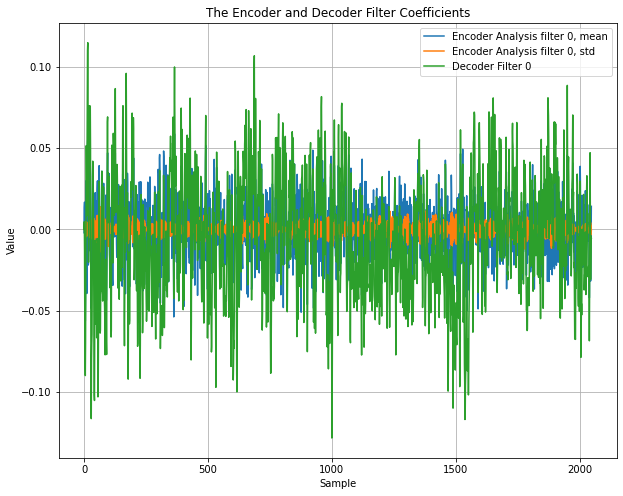

In [ ]:
# Show weighting post-training across encoder
print("MSE=", loss_fn(Ypred, Y).item(), "Variational Loss:", variational_loss(Yencmean, Yencstd).item())
ww = model.state_dict()   #read obtained weights
print("ww=", ww)
#Plot obtained weights:
plt.figure(figsize=(10,8))
plt.plot(np.transpose(np.array(ww['conv1mean.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['conv1std.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['synconv1.weight'][0:1,0,:])))
plt.legend(('Encoder Analysis filter 0, mean','Encoder Analysis filter 0, std', 'Decoder Filter 0'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('The Encoder and Decoder Filter Coefficients')
plt.grid()

In [ ]:
#Test on training set:
    
#predictions=model(X).cpu() # Make Predictions based on the obtained weights, on training set
#noisy case:
#predictions, Yencmean, Yencstd = model(X)
Yencmean=model.encodermean(X)
    
#no noise case
predclean=model.decoder(Yencmean)
predclean=predclean.detach() #no noise case
predclean=np.array(predclean)
    
#Add gaussian noise with unit standard deviation to encoded signal:
Yvariational= Yencmean + torch.randn_like(Yencmean)
predictions=model.decoder(Yvariational)
    
predictions=predictions.detach()
predictions=np.array(predictions)
Yencmean=np.array(Yencmean.detach())
Yencstd=np.array(Yencstd.detach())
print("Yencstd.shape=",Yencstd.shape)
    
Y=np.array(Y) #target
#print("Y=",Y)
print("predictions.shape=", predictions.shape)
#convert to numpy:
#https://discuss.pytorch.org/t/how-to-transform-variable-into-numpy/104/2

Yencstd.shape= (400, 512, 216)
predictions.shape= (400, 1, 220162)


In [ ]:
import IPython.display as ipd

"The training set output for clean encoded signal for batch0"
"The training set output for noisy encoded signal for batch0"
"The training set output for clean encoded signal for batch1"
"The training set output for noisy encoded signal for batch1"
"The training set output for clean encoded signal for batch2"
"The training set output for noisy encoded signal for batch2"
"The training set output for clean encoded signal for batch3"
"The training set output for noisy encoded signal for batch3"
"The training set output for clean encoded signal for batch4"
"The training set output for noisy encoded signal for batch4"
"The training set output for clean encoded signal for batch5"
"The training set output for noisy encoded signal for batch5"
"The training set output for clean encoded signal for batch6"
"The training set output for noisy encoded signal for batch6"
"The training set output for clean encoded signal for batch7"
"The training set output for noisy encoded signal for batch7"
"The tra

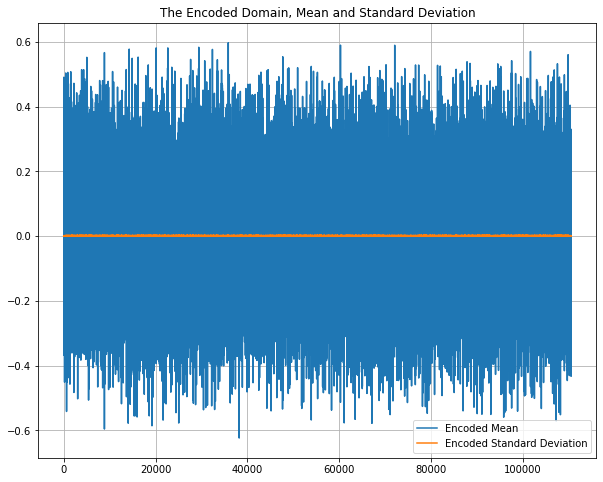

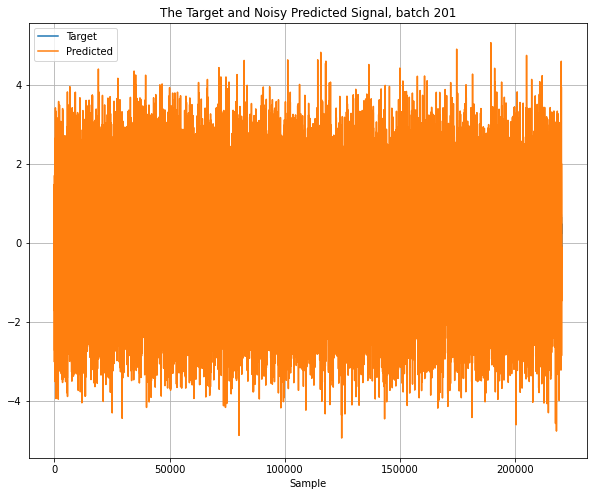

In [ ]:
#Plot target signal and output of autoencoder:
for b in range(batch):
    #print("np.reshape(Yencstd[b,:,:],(1,-1))", np.reshape(Yencstd[b,:,:],(1,-1)))
    if b == 201:
      plt.figure(figsize=(10,8))
      plt.plot(np.reshape(Yencmean[b,:,:],(1,-1))[0,:])
      plt.plot(np.reshape(Yencstd[b,:,:],(1,-1))[0,:])
      plt.legend(('Encoded Mean', 'Encoded Standard Deviation'))
      plt.title('The Encoded Domain, Mean and Standard Deviation')
      plt.grid()
      plt.figure(figsize=(10,8))
      plt.plot(np.array(Y[b,0,:]))
      plt.plot(predictions[b,0,:])
      plt.legend(('Target','Predicted'))
      plt.title('The Target and Noisy Predicted Signal, batch '+str(b))
      plt.xlabel('Sample')
      plt.grid()

    #No noise case:
    xrek=predclean[b,0,:]  #remove unnecessary dimension for playback
    xrek=np.clip(xrek, -1.0,1.0)
    wav.write('testrekvaeclean'+str(b)+'.wav', fs, np.int16(2**15*xrek))
    print('"The training set output for clean encoded signal for batch'+str(b)+'"')
    #display(ipd.Audio(2**15*xrek,rate=fs))
      
    xrek=predictions[b,0,:]  #remove unnecessary dimension for playback
    xrek=np.clip(xrek, -1.0,1.0)
    wav.write('testrekvae'+str(b)+'.wav', fs, np.int16(2**15*xrek))
    print('"The training set output for noisy encoded signal for batch'+str(b)+'"')
    #display(ipd.Audio(2**15*xrek,rate=fs))

The verification set input to the variational autoencoder


The verification set output for clean encoded signal


The verification set output for noisy encoded signal


Only noise as encoded signal
The decoded signal


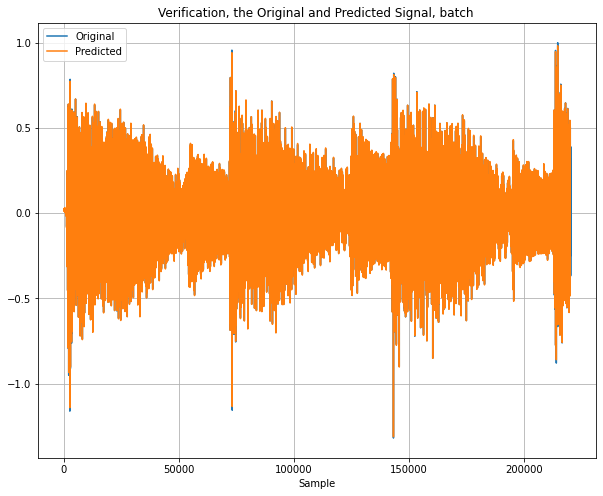

In [ ]:
#Test on Verification set:
fs, x = wav.read('/content/drive/MyDrive/Output_Files/verif_Music_1.wav')
# 7_19 10_35 11_1 12_16 13_26 14_40 15_24 16_4 19_20 48_37
#fs, x= wav.read('test2.wav')
#x=x*1.0/2**15 #normalize
x=x/max(x)
    
print("The verification set input to the variational autoencoder")
display(ipd.Audio(2**14*x,rate=fs))
X=signal2pytorch(x).to(device)
Yencmean=model.encodermean(X)

predclean=model.decoder(Yencmean)
predclean=predclean.detach() #no noise case
predclean=np.array(predclean)
    
#No noise case:
xrek=predclean[0,0,:]  #remove unnecessary dimension for playback
xrek=np.clip(xrek, -1.0,1.0)
#xrek = xrek/abs(max(xrek))
wav.write('testvervaeclean_vSet_1'+str(b)+'.wav', fs, np.int16(2**15*xrek))
print("The verification set output for clean encoded signal")
display(ipd.Audio(2**15*xrek, rate=fs))
    
#Add gaussian noise with unit standard deviation:
Yvariational= Yencmean + torch.randn_like(Yencmean)
predictions= model.decoder(Yvariational) # Make Predictions based on the obtained weights, on verification set
predictions=predictions.detach()
predictions=np.array(predclean)
b=0
plt.figure(figsize=(10,8))
plt.plot(np.array(X[b,0,:]))
plt.plot(predictions[b,0,:])
plt.legend(('Original','Predicted'))
plt.title('Verification, the Original and Predicted Signal, batch ')
plt.xlabel('Sample')
plt.grid()
xrek=predictions[:,0,:]
xrek=np.transpose(xrek)
xrek=np.clip(xrek, -1.0,1.0)
#xrek = xrek/max(xrek)
wav.write('testver.wav', fs, np.int16(2**15*xrek))
print("The verification set output for noisy encoded signal")
display(ipd.Audio('testver.wav', rate=fs))
print("Only noise as encoded signal")

Yvariational=  torch.randn_like(Yencmean)
predictions= model.decoder(Yvariational) # Make Predictions based on the obtained weights, on verification set
predictions=predictions.detach()
predictions=np.array(predictions)
xrek=predictions[:,0,:]
xrek=np.transpose(xrek)
xrek=np.clip(xrek, -1.0,1.0)
wav.write('noisevarout.wav', fs, np.int16(2**15*xrek))
print("The decoded signal")
display(ipd.Audio('noisevarout.wav', rate=fs))

In [ ]:
# ! ls -l 

total 383788
-rw-r--r-- 1 root root 37766127 Sep 19 15:56 audio_variational_autoenc.torch
drwx------ 6 root root     4096 Sep 19 05:38 drive
-rw-r--r-- 1 root root   440368 Sep 19 15:56 noisevarout.wav
drwxr-xr-x 1 root root     4096 Sep 16 13:40 sample_data
-rw-r--r-- 1 root root   440368 Sep 19 15:56 testrekvae0.wav
-rw-r--r-- 1 root root   440368 Sep 19 15:56 testrekvae100.wav
-rw-r--r-- 1 root root   440368 Sep 19 15:56 testrekvae101.wav
-rw-r--r-- 1 root root   440368 Sep 19 15:56 testrekvae102.wav
-rw-r--r-- 1 root root   440368 Sep 19 15:56 testrekvae103.wav
-rw-r--r-- 1 root root   440368 Sep 19 15:56 testrekvae104.wav
-rw-r--r-- 1 root root   440368 Sep 19 15:56 testrekvae105.wav
-rw-r--r-- 1 root root   440368 Sep 19 15:56 testrekvae106.wav
-rw-r--r-- 1 root root   440368 Sep 19 15:56 testrekvae107.wav
-rw-r--r-- 1 root root   440368 Sep 19 15:56 testrekvae108.wav
-rw-r--r-- 1 root root   440368 Sep 19 15:56 testrekvae109.wav
-rw-r--r-- 1 root root   440368 Sep 19 15:56 testr

In [ ]:
# ! zip natural_audio_2.zip *.wav 

  adding: noisevarout.wav (deflated 26%)
  adding: testrekvae0.wav (deflated 26%)
  adding: testrekvae100.wav (deflated 26%)
  adding: testrekvae101.wav (deflated 26%)
  adding: testrekvae102.wav (deflated 26%)
  adding: testrekvae103.wav (deflated 26%)
  adding: testrekvae104.wav (deflated 26%)
  adding: testrekvae105.wav (deflated 26%)
  adding: testrekvae106.wav (deflated 27%)
  adding: testrekvae107.wav (deflated 27%)
  adding: testrekvae108.wav (deflated 26%)
  adding: testrekvae109.wav (deflated 26%)
  adding: testrekvae10.wav (deflated 26%)
  adding: testrekvae110.wav (deflated 26%)
  adding: testrekvae111.wav (deflated 26%)
  adding: testrekvae112.wav (deflated 26%)
  adding: testrekvae113.wav (deflated 26%)
  adding: testrekvae114.wav (deflated 26%)
  adding: testrekvae115.wav (deflated 26%)
  adding: testrekvae116.wav (deflated 27%)
  adding: testrekvae117.wav (deflated 26%)
  adding: testrekvae118.wav (deflated 26%)
  adding: testrekvae119.wav (deflated 27%)
  adding: testre